# CSE 202:  *Power Grid* Experiments
## Winter 2025
### Melina Dimitropoulou Kapsogeorgou, Andrew Pan, Adrian Rosing, Andrew Russell, Benjamin Xia

In [ ]:
import itertools
import networkx as nx
from networkx.algorithms import tree
from concurrent.futures import ProcessPoolExecutor

## Pre-Game Initialization

In [3]:
def phase0_solve_kmst(G, K):
    V = list(G.nodes)
    E = list(G.edges)

    result_mst = None
    min_weight = float('inf')
    for Vp in itertools.combinations(V, K):
        subgraph = G.subgraph(Vp)
        if not nx.is_connected(subgraph):
            continue
        T = nx.minimum_spanning_tree(subgraph, algorithm='prim')
        total_cost = T.size(weight='weight')
        if total_cost < min_weight:
            result_mst = T
            min_weight = total_cost
    return (result_mst, min_weight)

In [4]:
G = nx.Graph([
    ('Seattle', 'Portland', { 'weight': 3 }),
    ('Seattle', 'Boise', { 'weight': 12 }),
    ('Seattle', 'Billings', { 'weight': 9 }),
    ('Portland', 'San Francisco', { 'weight': 24 }),
    ('Portland', 'Boise', { 'weight': 13 }),
    ('San Francisco', 'Los Angeles', { 'weight': 9 }),
    ('San Francisco', 'Las Vegas', { 'weight': 14 }),
    ('San Francisco', 'Salt Lake City', { 'weight': 27 }),
    ('San Francisco', 'Boise', { 'weight': 23 }),
    ('Boise', 'Billings', { 'weight': 12 }),
    ('Boise', 'Cheyenne', { 'weight': 24 }),
    ('Boise', 'Salt Lake City', { 'weight': 8 }),
    ('Las Vegas', 'Salt Lake City', { 'weight': 18 }),
    ('Las Vegas', 'Los Angeles', { 'weight': 9 }),
    ('Las Vegas', 'San Diego', { 'weight': 9 }),
    ('Las Vegas', 'Phoenix', { 'weight': 15 }),
    ('Las Vegas', 'Santa Fe', { 'weight': 27 }),
    ('Los Angeles', 'San Diego', { 'weight': 3 }),
    ('San Diego', 'Phoenix', { 'weight': 14 })
    # Etc.
])

Gp, min_weight = phase0_solve_kmst(G, 10)
nx.write_network_text(Gp)

╙── Billings
    └── Seattle
        ├── Boise
        │   └── Salt Lake City
        │       └── Las Vegas
        │           └── Los Angeles
        │               ├── San Diego
        │               │   └── Phoenix
        │               └── San Francisco
        └── Portland


In [ ]:
# Real Graph & Parallelization:
def evaluate_combination(args):
    G, nodes = args
    subgraph = G.subgraph(nodes)
    if not nx.is_connected(subgraph):
        return None
    T = nx.minimum_spanning_tree(subgraph, algorithm='prim')
    total_cost = T.size(weight='weight')
    return (nodes, T, total_cost)

def phase0_solve_kmst_parallel(G, K, workers=None):
    V = list(G.nodes)
    best_result = None
    min_weight = float('inf')
    
    # Create an iterable of all combinations along with the graph G
    combinations_iter = ((G, combo) for combo in itertools.combinations(V, K))
    
    # Use a process pool to parallelize the evaluation of each combination
    with ProcessPoolExecutor(max_workers=workers) as executor:
        for result in executor.map(evaluate_combination, combinations_iter):
            if result is None:
                continue
            _, T, total_cost = result
            if total_cost < min_weight:
                min_weight = total_cost
                best_result = T
    return best_result, min_weight

G = nx.Graph([
    ('Seattle', 'Portland', { 'weight': 3 }),
    ('Seattle', 'Boise', { 'weight': 12 }),
    ('Seattle', 'Billings', { 'weight': 9 }),
    ('Portland', 'San Francisco', { 'weight': 24 }),
    ('Portland', 'Boise', { 'weight': 13 }),
    ('San Francisco', 'Los Angeles', { 'weight': 9 }),
    ('San Francisco', 'Las Vegas', { 'weight': 14 }),
    ('San Francisco', 'Salt Lake City', { 'weight': 27 }),
    ('San Francisco', 'Boise', { 'weight': 23 }),
    ('Boise', 'Billings', { 'weight': 12 }),
    ('Boise', 'Cheyenne', { 'weight': 24 }),
    ('Boise', 'Salt Lake City', { 'weight': 8 }),
    ('Las Vegas', 'Salt Lake City', { 'weight': 18 }),
    ('Las Vegas', 'Los Angeles', { 'weight': 9 }),
    ('Las Vegas', 'San Diego', { 'weight': 9 }),
    ('Las Vegas', 'Phoenix', { 'weight': 15 }),
    ('Las Vegas', 'Santa Fe', { 'weight': 27 }),
    ('Los Angeles', 'San Diego', { 'weight': 3 }),
    ('San Diego', 'Phoenix', { 'weight': 14 }),
    ('Phoenix', 'Santa Fe', { 'weight': 18 }),
    ('Salt Lake City', 'Denver', { 'weight': 21 }),
    ('Salt Lake City', 'Santa Fe', { 'weight': 28 }),
    ('Billings', 'Cheyenne', { 'weight': 9 }),
    ('Billings', 'Fargo', { 'weight': 17 }),
    ('Billings', 'Minneapolis', { 'weight': 18 }),
    ('Cheyenne', 'Denver', { 'weight': 0}),
    ('Cheyenne', 'Minneapolis', { 'weight': 18 }),
    ('Cheyenne', 'Omaha', { 'weight': 14 }),
    ('Denver', 'Kansas City', { 'weight': 16 }),
    ('Denver', 'Santa Fe', { 'weight': 13 }),
    ('Santa Fe', 'Kansas City', { 'weight': 16 }),
    ('Santa Fe', 'Oklahoma City', { 'weight': 15 }),
    ('Santa Fe', 'Dallas', { 'weight': 16 }),
    ('Santa Fe', 'Houston', { 'weight': 21 }),
    ('Fargo', 'Minneapolis', { 'weight': 6 }),
    ('Fargo', 'Duluth', { 'weight': 6 }),
    ('Minneapolis', 'Duluth', { 'weight': 5 }),
    ('Minneapolis', 'Omaha', { 'weight': 8 }),
    ('Minneapolis', 'Chicago', { 'weight': 8 }),
    ('Duluth', 'Chicago', { 'weight': 12 }),
    ('Duluth', 'Detroit', { 'weight': 15 }),
    ('Omaha', 'Kansas City', { 'weight': 5 }),
    ('Omaha', 'Chicago', { 'weight': 13 }),
    ('Kansas City', 'Chicago', { 'weight': 8 }),
    ('Kansas City', 'St. Louis', { 'weight': 6 }),
    ('Kansas City', 'Memphis', { 'weight': 12 }),
    ('Kansas City', 'Oklahoma City', { 'weight': 8 }),
    ('Oklahoma City', 'Memphis', { 'weight': 14 }),
    ('Oklahoma City', 'Dallas', { 'weight': 3 }),
    ('Dallas', 'Houston', { 'weight': 5 }),
    ('Dallas', 'Memphis', { 'weight': 12 }),
    ('Dallas', 'New Orleans', { 'weight': 12 }),
    ('Houston', 'New Orleans', { 'weight': 8 }),
    ('New Orleans', 'Memphis', { 'weight': 7 }),
    ('New Orleans', 'Birmingham', { 'weight': 11 }),
    ('New Orleans', 'Jacksonville', { 'weight': 16 }),
    ('Memphis', 'St. Louis', { 'weight': 7 }),
    ('Memphis', 'Birmingham', { 'weight': 6 }),
    ('St. Louis', 'Chicago', { 'weight': 10 }),
    ('St. Louis', 'Cincinnati', { 'weight': 12 }),
    ('St. Louis', 'Atlanta', { 'weight': 12 }),
    ('Chicago', 'Detroit', { 'weight': 7 }),
    ('Chicago', 'Cincinnati', { 'weight': 7 }),
    ('Detroit', 'Cincinnati', { 'weight': 4 }),
    ('Detroit', 'Buffalo', { 'weight': 7 }),
    ('Detroit', 'Pittsburgh', { 'weight': 6 }),
    ('Cincinnati', 'Pittsburgh', { 'weight': 7 }),
    ('Cincinnati', 'Raleigh', { 'weight': 15 }),
    ('Cincinnati', 'Knoxville', { 'weight': 6 }),
    ('Knoxville', 'Atlanta', { 'weight': 5 }),
    ('Birmingham', 'Atlanta', { 'weight': 3 }),
    ('Birmingham', 'Jacksonville', { 'weight': 9 }),
    ('Atlanta', 'Raleigh', { 'weight': 7 }),
    ('Atlanta', 'Savannah', { 'weight': 7 }),
    ('Miami', 'Tampa', { 'weight': 4 }),
    ('Tampa', 'Jacksonville', { 'weight': 4 }),
    ('Jacksonville', 'Savannah', { 'weight': 0 }),
    ('Savannah', 'Raleigh', { 'weight': 7 }),
    ('Raleigh', 'Norfolk', { 'weight': 3 }),
    ('Raleigh', 'Pittsburgh', { 'weight': 7 }),
    ('Pittsburgh', 'Buffalo', { 'weight': 7 }),
    ('Pittsburgh', 'Washington', { 'weight': 6 }),
    ('Buffalo', 'New York', { 'weight': 8 }),
    ('Boston', 'New York', { 'weight': 3 }),
    ('New York', 'Philadelphia', { 'weight': 0 }),
    ('Philadelphia', 'Washington', { 'weight': 3 }),
    ('Washington', 'Norfolk', { 'weight': 5 })
])

Gp, min_weight = phase0_solve_kmst_parallel(G, 15)
nx.write_network_text(Gp)


## *Purchase Power Plants* Phase

In [5]:
def argmin(a):
    if len(a) == 0:
        return 0
    return min(range(len(a)), key=lambda x : a[x])
def argmax(a):
    if len(a) == 0:
        return 0
    return max(range(len(a)), key=lambda x : a[x])

def max_pow(P, f, ResourceCost, K):
    dp = []
    Pp = []
    if f <= 0:
        return (0, 0, dp, Pp)
    for i in range(len(P) + 1):
        dp.append([0 for j in range(f + 1)])
        Pp.append([set() for j in range(f + 1)])
    for i in range(1, len(P) + 1):
        c, rt, ra, e = P[i - 1]
        running_cost = ra * ResourceCost[rt]
        for j in range(1, f + 1):
            no_change = dp[i - 1][j]
            add_plant = dp[i - 1][max(0, j - running_cost)] + e
            if j - running_cost <= 0 or no_change > add_plant:
                dp[i][j] = dp[i - 1][j]
                Pp[i][j] = Pp[i - 1][j].copy()
            else:
                dp[i][j] = add_plant
                Pp[i][j] = Pp[i - 1][j - running_cost] | set(P[i - 1:i])
    if max(dp[len(P)]) < K:
        return (
            max(dp[len(P)]),
            argmax(dp[len(P)]),
            dp,
            Pp
        )
    return (
        min([ x for x in dp[len(P)] if x >= K ]),
        argmin([ x for x in dp[len(P)] if x >= K ]),
        dp,
        Pp
    )

def phase1_purchase_power_plants(P, f, P_player, P_max, ResourceCost, K):
    # No purchase decision
    m0, c0, _, _ = max_pow(P_player, f, ResourceCost, K)

    # Purchase decision, no eviction decision
    m1 = 0
    c1 = 0
    p1 = None
    for i, p in enumerate(P):
        c_i, rt, ra, e = p
        m, c, _, _ = max_pow(P_player + [p], f - c_i, ResourceCost, K)
        c += c_i
        if m > m1 or (m == m1 and c < c1):
            m1 = m
            c1 = c
            p1 = p

    # Purchase decision, eviction decision
    m2 = 0
    c2 = 0
    p2 = None
    d2 = None
    if len(P_player) > 0:
        for i, p in enumerate(P):
            c_i, rt, ra, e = p
            for pp in itertools.combinations(P_player, len(P_player) - 1):
                m, c, _, _ = max_pow([*pp, p], f - c_i, ResourceCost, K)
                c += c_i
                if m > m2 or (m == m2 and c < c2):
                    m2 = m
                    c2 = c
                    p2 = p
                    e2 = list(set(P_player) - set(pp))[0]

    out_p = None
    out_d = None
    if m0 >= m1 and m0 >= m2: # Doing nothing is best
        return out_p, out_d

    if m1 > m2 or (m1 == m2 and c1 <= c2):
        out_p = p1
    elif m2 > m1 or (m1 == m2 and c2 < c1):
        out_p = p2
        out_d = d2
    return out_p, out_d

In [ ]:
P = [
    (4, 'Coal', 2, 1),
    (8, 'Coal', 3, 2),
    (10, 'Coal', 2, 2),
    (15, 'Coal', 2, 3),
    (20, 'Coal', 3, 5),
    (25, 'Coal', 2, 5),
    (31, 'Coal', 3, 6),
    (36, 'Coal', 3, 7),
    (42, 'Coal', 2, 6),

    (3, 'Oil', 2, 1),
    (7, 'Oil', 3, 2),
    (9, 'Oil', 1, 1),
    (16, 'Oil', 2, 3),
    (26, 'Oil', 2, 5),
    (32, 'Oil', 3, 6),
    (35, 'Oil', 1, 5),
    (40, 'Oil', 2, 6),

    (6, 'Trash', 1, 1),
    (14, 'Trash', 2, 2),
    (19, 'Trash', 2, 3),
    (24, 'Trash', 2, 4),
    (30, 'Trash', 3, 6),
    (38, 'Trash', 3, 7),

    (11, 'Uranium', 1, 2),
    (17, 'Uranium', 1, 2),
    (23, 'Uranium', 1, 3),
    (28, 'Uranium', 1, 4),
    (34, 'Uranium', 1, 5),
    (39, 'Uranium', 1, 6),

    (13, 'Wind', 0, 1),
    (18, 'Wind', 0, 2),
    (22, 'Wind', 0, 2),
    (27, 'Wind', 0, 3),
    (33, 'Wind', 0, 4),
    (37, 'Wind', 0, 4),
    (44, 'Wind', 0, 5),
    (50, 'Wind', 0, 6)
]
f = 50 # Money

P_player = [ ]

P_max = 3

ResourceCost = {
    'Wind': 0,
    'Coal': 2,
    'Oil': 3,
    'Trash': 7,
    'Uranium': 14
}

K = 15

phase1_purchase_power_plants(P, f, P_player, P_max, ResourceCost, K)

((36, 'Coal', 3, 7), None)

In [ ]:
# Full Power Plants:

P = [
    (4, 'Coal', 2, 1),
    (8, 'Coal', 3, 2),
    (10, 'Coal', 2, 2),
    (15, 'Coal', 2, 3),
    (20, 'Coal', 3, 5),
    (25, 'Coal', 2, 5),
    (31, 'Coal', 3, 6),
    (36, 'Coal', 3, 7),
    (42, 'Coal', 2, 6),

    (3, 'Oil', 2, 1),
    (7, 'Oil', 3, 2),
    (9, 'Oil', 1, 1),
    (16, 'Oil', 2, 3),
    (26, 'Oil', 2, 5),
    (32, 'Oil', 3, 6),
    (35, 'Oil', 1, 5),
    (40, 'Oil', 2, 6),

    (6, 'Trash', 1, 1),
    (14, 'Trash', 2, 2),
    (19, 'Trash', 2, 3),
    (24, 'Trash', 2, 4),
    (30, 'Trash', 3, 6),
    (38, 'Trash', 3, 7),

    (11, 'Uranium', 1, 2),
    (17, 'Uranium', 1, 2),
    (23, 'Uranium', 1, 3),
    (28, 'Uranium', 1, 4),
    (34, 'Uranium', 1, 5),
    (39, 'Uranium', 1, 6)
]
f = 50
P_player = [
    (31, 'Coal', 3, 6),
    (36, 'Coal', 3, 7),
    (5, 'Uranium', 1, 1),
]
P_max = 3
ResourceCost = {
    'Coal': 1,
    'Oil': 2,
    'Trash': 5,
    'Uranium': 10
}
K = 10

phase1_purchase_power_plants(P, f, P_player, P_max, ResourceCost, K)

## *Purchasing Resources*/*Building Connections*/*Powering Plants* Phase 

In [107]:
def phase2_purchase_build_power(P, Gp, C, f, ResourceCost, K, B):
    Vp = list(Gp.nodes)
    mst = list(tree.minimum_spanning_edges(G, algorithm='prim'))

    Prefix = [0]
    for i in range(1, len(mst) + 1):
        Prefix.append(Prefix[i - 1] + mst[i - 1][2]['weight'])

    MP, MC, dp, Pp = max_pow(P, f, ResourceCost, K)

    i = argmax([
        min(dp[len(P)][max(0, f - Prefix[i])], len(C) + i)
            for i in range(1, min(len(Prefix), len(Vp) - len(C) + 1))
    ])
    M = len(C) + i

    if M >= K:
        i_star = min(dp[len(P)][f - Prefix[i]], len(C) + i)
    else:
        # options = [
        #     max([f - Prefix[i] - j + B * min(dp[len(P)][j], len(C) + i)])
        #         for j in range(0, max(0, f - Prefix[i] + 1))
        # ]
        # i_star = argmax(options)
        # print(f"i_star: {i_star}, cash: {max(options)}")
        i_star = -1
        i_best = 0
        cities_powered = 0
        for i in range(len(Prefix)):
            for j in range(f - Prefix[i] + 1):
                cash = f - Prefix[i] - j + min(dp[len(P)][j], len(C) + i) * B
                if cash > i_best:
                    cities_powered = min(dp[len(P)][j], len(C) + i)
                    i_best = cash
                    i_star = i
        # print(f"i_star: {i_star}, cash: {i_best}, cities powered: {cities_powered}")

    # figure out why Pnew is empty -> Rt and Q are still empty lists
    e = mst[0:(i_star)]
    P_new = list(Pp[len(P)][f])# - set(P)) <- TODO: I think this was bug?
    # print(f"Existing P: {P}")
    # print(f"Pp[len(P)][f]: {Pp[len(P)][f]}")
    # print(f"Difference: {Pp[len(P)][f] - set(P)}")
    
    Rt = [ rt for (_, rt, _, _) in P_new ]
    Q = [ ra for (_, _, ra, _) in P_new ]
    return (Rt, Q), e, P_new

C = ['San Francisco', 'Boise', 'Las Vegas']
B = 9

phase2_purchase_build_power(P_player, G, C, f, ResourceCost, K, B)

((['Coal', 'Coal', 'Uranium'], [3, 3, 1]),
 [('Salt Lake City', 'Boise', {'weight': 8}),
  ('Boise', 'Seattle', {'weight': 12}),
  ('Seattle', 'Portland', {'weight': 3}),
  ('Seattle', 'Billings', {'weight': 9}),
  ('Salt Lake City', 'Denver', {'weight': 16}),
  ('Denver', 'Cheyenne', {'weight': 2}),
  ('Denver', 'Santa Fe', {'weight': 7}),
  ('Santa Fe', 'El Paso', {'weight': 13}),
  ('El Paso', 'Phoenix', {'weight': 10}),
  ('Phoenix', 'Los Angeles', {'weight': 13}),
  ('Los Angeles', 'San Diego', {'weight': 3}),
  ('Los Angeles', 'San Francisco', {'weight': 9})],
 [(31, 'Coal', 3, 6), (36, 'Coal', 3, 7), (5, 'Uranium', 1, 1)])

In [23]:
C = ['San Francisco', 'Boise', 'Las Vegas']
B = 1
phase2_purchase_build_power(P_player, G, C, f, ResourceCost, K, B)


i_star: 0, cash: 34, cities powered: 0
Existing P: [(31, 'Coal', 3, 6), (36, 'Coal', 3, 7), (5, 'Uranium', 1, 1)]
Pp[len(P)][f]: {(31, 'Coal', 3, 6), (36, 'Coal', 3, 7), (5, 'Uranium', 1, 1)}
Difference: set()


((['Coal', 'Coal', 'Uranium'], [3, 3, 1]),
 [],
 [(31, 'Coal', 3, 6), (36, 'Coal', 3, 7), (5, 'Uranium', 1, 1)])

# Experimentation

## Pre-Game Initialization

In [9]:
#Scaling with size of graph
import time
import math

connections = [
    ('Seattle', 'Boise', { 'weight': 12 }),
    ('Seattle', 'Billings', { 'weight': 9 }),
    ('Seattle', 'Portland', { 'weight': 3 }),
    ('Seattle', 'San Francisco', { 'weight': 18 }),
    ('Seattle', 'Salt Lake City', { 'weight': 22 }),
    ('Portland', 'San Francisco', { 'weight': 24 }),
    ('Portland', 'Boise', { 'weight': 13 }),
    ('Portland', 'Salt Lake City', { 'weight': 19 }),
    ('Portland', 'Las Vegas', { 'weight': 26 }),
    ('San Francisco', 'Los Angeles', { 'weight': 9 }),
    ('San Francisco', 'Las Vegas', { 'weight': 14 }),
    ('San Francisco', 'Salt Lake City', { 'weight': 27 }),
    ('San Francisco', 'Boise', { 'weight': 23 }),
    ('San Francisco', 'Phoenix', { 'weight': 20 }),
    ('San Francisco', 'Santa Fe', { 'weight': 30 }),
    ('Boise', 'Billings', { 'weight': 12 }),
    ('Boise', 'Cheyenne', { 'weight': 24 }),
    ('Boise', 'Salt Lake City', { 'weight': 8 }),
    ('Boise', 'Denver', { 'weight': 20 }),
    ('Boise', 'Santa Fe', { 'weight': 29 }),
    ('Billings', 'Cheyenne', { 'weight': 17 }),
    ('Billings', 'Denver', { 'weight': 20 }),
    ('Billings', 'Salt Lake City', { 'weight': 19 }),
    ('Billings', 'Santa Fe', { 'weight': 31 }),
    ('Cheyenne', 'Denver', { 'weight': 2 }),
    ('Cheyenne', 'Salt Lake City', { 'weight': 21 }),
    ('Cheyenne', 'Santa Fe', { 'weight': 19 }),
    ('Las Vegas', 'Salt Lake City', { 'weight': 18 }),
    ('Las Vegas', 'Los Angeles', { 'weight': 9 }),
    ('Las Vegas', 'San Diego', { 'weight': 9 }),
    ('Las Vegas', 'Phoenix', { 'weight': 15 }),
    ('Las Vegas', 'Santa Fe', { 'weight': 27 }),
    ('Las Vegas', 'Denver', { 'weight': 22 }),
    ('Los Angeles', 'San Diego', { 'weight': 3 }),
    ('Los Angeles', 'Phoenix', { 'weight': 13 }),
    ('Los Angeles', 'Santa Fe', { 'weight': 28 }),
    ('San Diego', 'Phoenix', { 'weight': 14 }),
    ('San Diego', 'El Paso', { 'weight': 24 }),
    ('Phoenix', 'Santa Fe', { 'weight': 22 }),
    ('Phoenix', 'Denver', { 'weight': 28 }),
    ('Phoenix', 'El Paso', { 'weight': 10 }),
    ('Santa Fe', 'Denver', { 'weight': 7 }),
    ('Santa Fe', 'El Paso', { 'weight': 13 }),
    ('Denver', 'Salt Lake City', { 'weight': 16 }),
    ('Denver', 'El Paso', { 'weight': 21 }),
    ('Denver', 'Kansas City', { 'weight': 24 }),
    ('El Paso', 'San Antonio', { 'weight': 15 }),
    ('El Paso', 'Dallas', { 'weight': 19 }),
    ('Kansas City', 'Dallas', { 'weight': 21 }),
    ('Dallas', 'San Antonio', { 'weight': 16 })
]

def num_con_exp():
    times = []
    for i in range(10, len(connections)):
        G = nx.Graph(connections[:i])
        start = time.time()
        Gp, min_weight = phase0_solve_kmst(G, 10)
        end = time.time()
        if not math.isinf(min_weight):
            times += [(i, end-start,min_weight)]
            # nx.write_network_text(Gp)
    return times


num_con_res = num_con_exp()



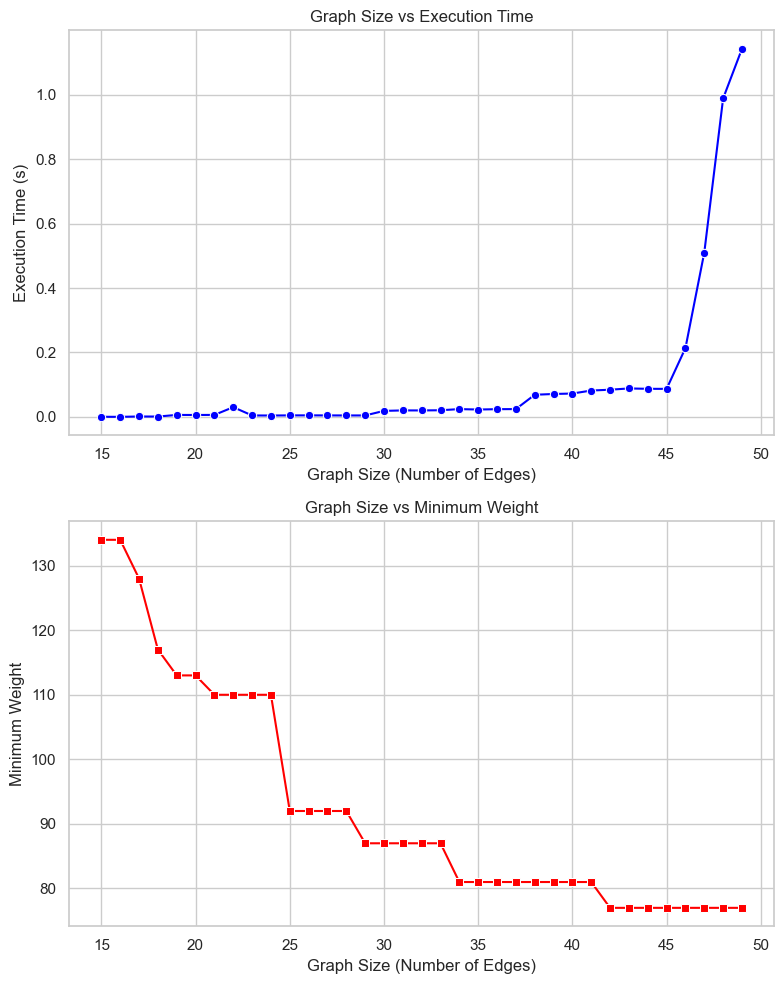

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sizes = [x[0] for x in num_con_res]
times = [x[1] for x in num_con_res]
min_weights = [x[2] for x in num_con_res]

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # Two rows, one column

# Execution Time
sns.lineplot(x=sizes, y=times, marker='o', color='blue', ax=axes[0])
axes[0].set_title("Graph Size vs Execution Time")
axes[0].set_xlabel("Graph Size (Number of Edges)")
axes[0].set_ylabel("Execution Time (s)")

#  Minimum Weight
sns.lineplot(x=sizes, y=min_weights, marker='s', color='red', ax=axes[1])
axes[1].set_title("Graph Size vs Minimum Weight")
axes[1].set_xlabel("Graph Size (Number of Edges)")
axes[1].set_ylabel("Minimum Weight")

plt.tight_layout()
plt.show()


In [11]:
# scaling with number of cities needed
def num_k_exp():
    times = []
    G = nx.Graph(connections)
    for i in range(1, len(connections)+1):
        start = time.time()
        Gp, min_weight = phase0_solve_kmst(G, i)
        end = time.time()
        if not math.isinf(min_weight):
            times += [(i, end-start,min_weight)]
            # nx.write_network_text(Gp)
    return times


num_k_res = num_k_exp()


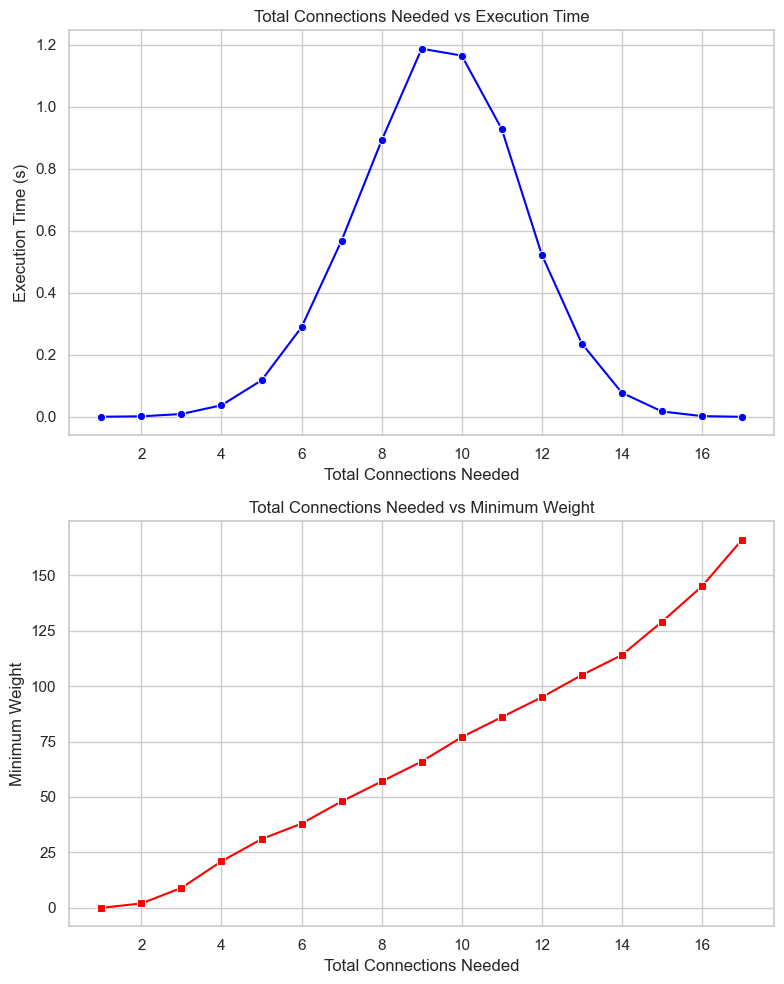

In [12]:

ks = [x[0] for x in num_k_res]
times = [x[1] for x in num_k_res]
min_weights = [x[2] for x in num_k_res]

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # Two rows, one column

#  Execution Time
sns.lineplot(x=ks, y=times, marker='o', color='blue', ax=axes[0])
axes[0].set_title("Total Connections Needed vs Execution Time")
axes[0].set_xlabel("Total Connections Needed")
axes[0].set_ylabel("Execution Time (s)")

# Plot Minimum Weight
sns.lineplot(x=ks, y=min_weights, marker='s', color='red', ax=axes[1])
axes[1].set_title("Total Connections Needed vs Minimum Weight")
axes[1].set_xlabel("Total Connections Needed")
axes[1].set_ylabel("Minimum Weight")

# Layout adjustments
plt.tight_layout()
plt.show()

## *Purchase Power Plants* Phase

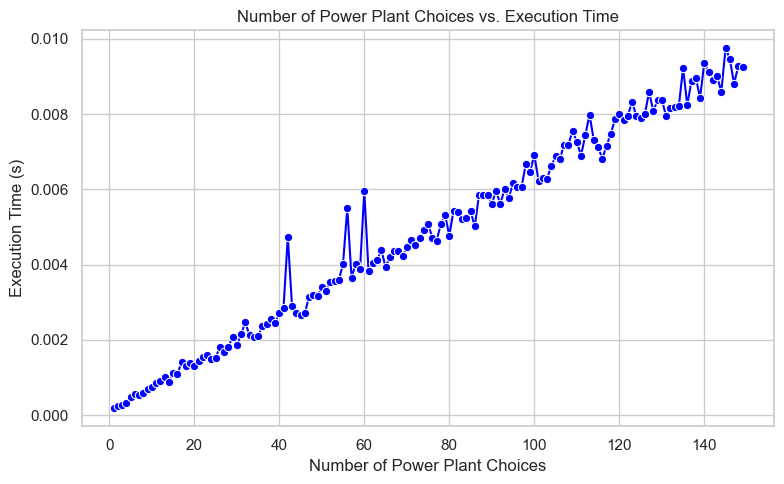

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import random

f = 50
P_player = [
    (31, 'Coal', 3, 6),
    (36, 'Coal', 3, 7),
    (5, 'Uranium', 1, 1),
]
P_max = 3
ResourceCost = {
    'Coal': 1,
    'Oil': 2,
    'Trash': 5,
    'Uranium': 10
}
K = 10

xs = []
ys = []
max_p = 150
n_trials = 10
for i in range(1, max_p):
    avg = 0
    for j in range(n_trials):
        plants = []
        for k in range(i):
            plants.append((
                random.randint(1, 100),
                ['Coal', 'Oil', 'Trash', 'Uranium'][random.randint(0, 3)],
                random.randint(1, 4),
                random.randint(1, 8)
            ))

        start = time.time()
        phase1_purchase_power_plants(plants, f, P_player, P_max, ResourceCost, K)
        end = time.time()
        avg += end - start

    xs.append(i)
    ys.append(avg / n_trials)

sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x=xs, y=ys, marker='o', color='blue', ax=ax)
ax.set_title("Number of Power Plant Choices vs. Execution Time")
ax.set_xlabel("Number of Power Plant Choices")
ax.set_ylabel("Execution Time (s)")

plt.tight_layout()
plt.show()

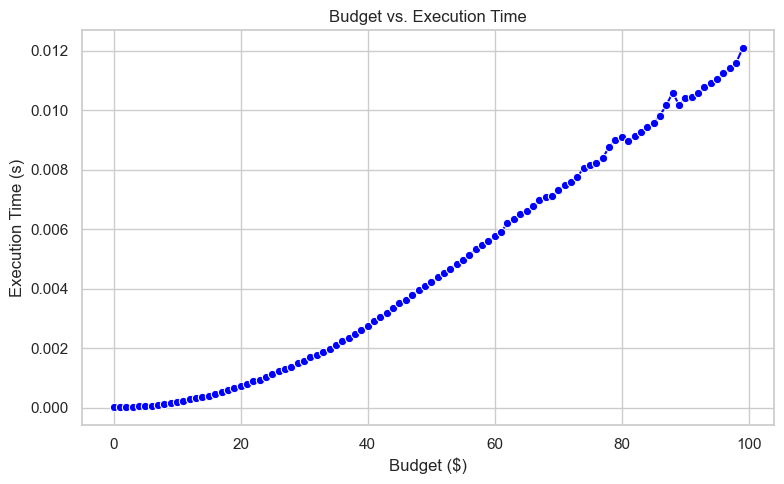

In [14]:
xs = []
ys = []
max_f = 100
n_trials = 10
for i in range(0, max_f):
    avg = 0
    for j in range(n_trials):
        start = time.time()
        phase1_purchase_power_plants(P, i, P_player, P_max, ResourceCost, K)
        end = time.time()
        avg += end - start

    xs.append(i)
    ys.append(avg / n_trials)

sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x=xs, y=ys, marker='o', color='blue', ax=ax)
ax.set_title("Budget vs. Execution Time")
ax.set_xlabel("Budget ($)")
ax.set_ylabel("Execution Time (s)")

plt.tight_layout()
plt.show()

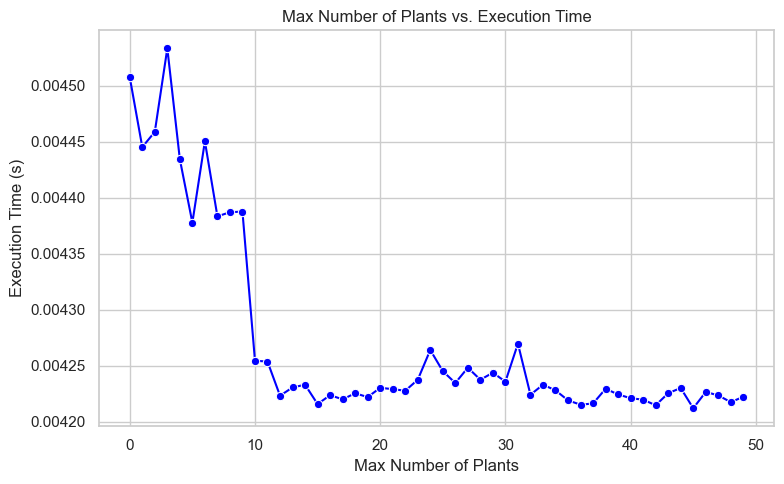

In [15]:
xs = []
ys = []
max_pmax = 50
n_trials = 10
for i in range(0, max_pmax):
    avg = 0
    for j in range(n_trials):
        start = time.time()
        phase1_purchase_power_plants(P, f, P_player, i, ResourceCost, K)
        end = time.time()
        avg += end - start

    xs.append(i)
    ys.append(avg / n_trials)

sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x=xs, y=ys, marker='o', color='blue', ax=ax)
ax.set_title("Max Number of Plants vs. Execution Time")
ax.set_xlabel("Max Number of Plants")
ax.set_ylabel("Execution Time (s)")

plt.tight_layout()
plt.show()

## *Purchasing Resources*/*Building Connections*/*Powering Plants* Phase 

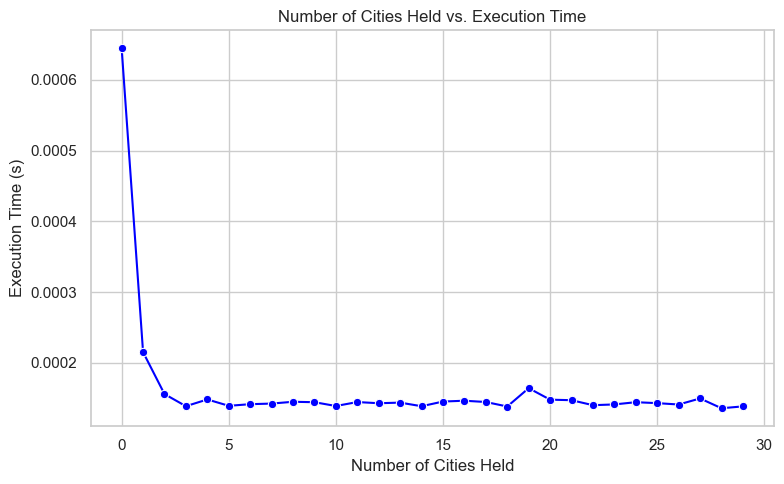

In [16]:
G = nx.gnp_random_graph(30, 0.3)
for u, v in G.edges():
    G.edges[u, v]['weight'] = random.randint(1, 20)

Gp, _ = phase0_solve_kmst(G, 30)
B = 1

xs = []
ys = []
max_c = len(G.nodes)
n_trials = 20
for i in range(0, max_c):
    avg = 0
    for j in range(n_trials):
        start = time.time()
        phase2_purchase_build_power(P_player, Gp, list(G.nodes)[None:0:None][:i], f, ResourceCost, K, B)
        end = time.time()
        avg += end - start

    xs.append(i)
    ys.append(avg / n_trials)

sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x=xs, y=ys, marker='o', color='blue', ax=ax)
ax.set_title("Number of Cities Held vs. Execution Time")
ax.set_xlabel("Number of Cities Held")
ax.set_ylabel("Execution Time (s)")

plt.tight_layout()
plt.show()

In [117]:
# G = nx.Graph([
#     ('Seattle', 'Portland', { 'weight': 3 }),
#     ('Seattle', 'Boise', { 'weight': 12 }),
#     ('Seattle', 'Billings', { 'weight': 9 }),
#     ('Portland', 'San Francisco', { 'weight': 24 }),
#     ('Portland', 'Boise', { 'weight': 13 }),
#     ('San Francisco', 'Los Angeles', { 'weight': 9 }),
#     ('San Francisco', 'Las Vegas', { 'weight': 14 }),
#     ('San Francisco', 'Salt Lake City', { 'weight': 27 }),
#     ('San Francisco', 'Boise', { 'weight': 23 }),
#     ('Boise', 'Billings', { 'weight': 12 }),
#     ('Boise', 'Cheyenne', { 'weight': 24 }),
#     ('Boise', 'Salt Lake City', { 'weight': 8 }),
#     ('Las Vegas', 'Salt Lake City', { 'weight': 18 }),
#     ('Las Vegas', 'Los Angeles', { 'weight': 9 }),
#     ('Las Vegas', 'San Diego', { 'weight': 9 }),
#     ('Las Vegas', 'Phoenix', { 'weight': 15 }),
#     ('Las Vegas', 'Santa Fe', { 'weight': 27 }),
#     ('Los Angeles', 'San Diego', { 'weight': 3 }),
#     ('San Diego', 'Phoenix', { 'weight': 14 })
#     # Etc.
# ])




def full_game_sim(board_size, K, B, f):
    connections = [
        ('Seattle', 'Boise', { 'weight': 12 }),
        ('Seattle', 'Billings', { 'weight': 9 }),
        ('Seattle', 'Portland', { 'weight': 3 }),
        ('Seattle', 'San Francisco', { 'weight': 18 }),
        ('Seattle', 'Salt Lake City', { 'weight': 22 }),
        ('Portland', 'San Francisco', { 'weight': 24 }),
        ('Portland', 'Boise', { 'weight': 13 }),
        ('Portland', 'Salt Lake City', { 'weight': 19 }),
        ('Portland', 'Las Vegas', { 'weight': 26 }),
        ('San Francisco', 'Los Angeles', { 'weight': 9 }),
        ('San Francisco', 'Las Vegas', { 'weight': 14 }),
        ('San Francisco', 'Salt Lake City', { 'weight': 27 }),
        ('San Francisco', 'Boise', { 'weight': 23 }),
        ('San Francisco', 'Phoenix', { 'weight': 20 }),
        ('San Francisco', 'Santa Fe', { 'weight': 30 }),
        ('Boise', 'Billings', { 'weight': 12 }),
        ('Boise', 'Cheyenne', { 'weight': 24 }),
        ('Boise', 'Salt Lake City', { 'weight': 8 }),
        ('Boise', 'Denver', { 'weight': 20 }),
        ('Boise', 'Santa Fe', { 'weight': 29 }),
        ('Billings', 'Cheyenne', { 'weight': 17 }),
        ('Billings', 'Denver', { 'weight': 20 }),
        ('Billings', 'Salt Lake City', { 'weight': 19 }),
        ('Billings', 'Santa Fe', { 'weight': 31 }),
        ('Cheyenne', 'Denver', { 'weight': 2 }),
        ('Cheyenne', 'Salt Lake City', { 'weight': 21 }),
        ('Cheyenne', 'Santa Fe', { 'weight': 19 }),
        ('Las Vegas', 'Salt Lake City', { 'weight': 18 }),
        ('Las Vegas', 'Los Angeles', { 'weight': 9 }),
        ('Las Vegas', 'San Diego', { 'weight': 9 }),
        ('Las Vegas', 'Phoenix', { 'weight': 15 }),
        ('Las Vegas', 'Santa Fe', { 'weight': 27 }),
        ('Las Vegas', 'Denver', { 'weight': 22 }),
        ('Los Angeles', 'San Diego', { 'weight': 3 }),
        ('Los Angeles', 'Phoenix', { 'weight': 13 }),
        ('Los Angeles', 'Santa Fe', { 'weight': 28 }),
        ('San Diego', 'Phoenix', { 'weight': 14 }),
        ('San Diego', 'El Paso', { 'weight': 24 }),
        ('Phoenix', 'Santa Fe', { 'weight': 22 }),
        ('Phoenix', 'Denver', { 'weight': 28 }),
        ('Phoenix', 'El Paso', { 'weight': 10 }),
        ('Santa Fe', 'Denver', { 'weight': 7 }),
        ('Santa Fe', 'El Paso', { 'weight': 13 }),
        ('Denver', 'Salt Lake City', { 'weight': 16 }),
        ('Denver', 'El Paso', { 'weight': 21 }),
        ('Denver', 'Kansas City', { 'weight': 24 }),
        ('El Paso', 'San Antonio', { 'weight': 15 }),
        ('El Paso', 'Dallas', { 'weight': 19 }),
        ('Kansas City', 'Dallas', { 'weight': 21 }),
        ('Dallas', 'San Antonio', { 'weight': 16 })
    ]
    P = [
        (4, 'Coal', 2, 1),
        (8, 'Coal', 3, 2),
        (10, 'Coal', 10, 2),
        (15, 'Coal', 2, 3),
        (20, 'Coal', 3, 5),
        (25, 'Coal', 2, 5),
        (31, 'Coal', 3, 6),
        (36, 'Coal', 3, 7),
        (42, 'Coal', 2, 6),

        (3, 'Oil', 2, 1),
        (7, 'Oil', 3, 2),
        (9, 'Oil', 1, 1),
        (16, 'Oil', 2, 3),
        (26, 'Oil', 2, 5),
        (32, 'Oil', 3, 6),
        (35, 'Oil', 1, 5),
        (40, 'Oil', 2, 6),

        (6, 'Trash', 1, 1),
        (14, 'Trash', 2, 2),
        (19, 'Trash', 2, 3),
        (24, 'Trash', 2, 4),
        (30, 'Trash', 3, 6),
        (38, 'Trash', 3, 7),

        (11, 'Uranium', 1, 2),
        (17, 'Uranium', 1, 2),
        (23, 'Uranium', 1, 3),
        (28, 'Uranium', 1, 4),
        (34, 'Uranium', 1, 5),
        (39, 'Uranium', 1, 6)
    ]

    P_max = 3
    ResourceCost = {
        'Coal': 1,
        'Oil': 2,
        'Trash': 5,
        'Uranium': 10
    }
    G = nx.Graph(connections[:board_size])
    C = set()
    Gp, min_weight = phase0_solve_kmst(G, K)
    P_player = []
    Powered = []
    turns = 0
    f_history = [f]
    powered_history = [0]
    P_player_history = [0]
    while (len(Powered) < K):
        turns+=1
        f = max(0, f)
        buy, discard = phase1_purchase_power_plants(P, f, P_player, P_max, ResourceCost, K)
        # print(f'buy; {buy}')
        # print(f'discard; {discard}')
        if buy != None: # buy plant - add to owned and deduct cost
            P_player.append(buy)
            P.remove(buy)
            f -= buy[0]
        if discard != None: #discard
            P_player.remove(discard)
        # print(f'P_player; {P_player}')
        # print(f'f; {f}')

        resources, connections, plants = phase2_purchase_build_power(P_player, Gp, C, f, ResourceCost, K, B)
        # print(f'resources; {resources}')
        # print(f'connections; {connections}')
        # print(f'plants; {plants}')
        # buy resources
        f -= sum([ResourceCost[q]*c for q, c in zip(resources[0], resources[1])])
        # print(f'f; {f}')

        # buy cities + deduct cost
        [(C.add(c[0]),C.add(c[1])) for c in connections]
        f -= sum(c[2]['weight'] for c in connections)
        # print(f'C; {C}')
        # print(f'f; {f}')
        # manage powered/available plants
        [(Powered.append(p), P_player.remove(p)) for p in plants]
        # print(f'Powered; {Powered}')
        # print(f'P_player; {P_player}')

        # add funds for powered cities
        f += 10 * len(Powered)
        f_history += [f]
        powered_history += [len(Powered)]
        P_player_history += [len(P_player)]
    return turns, f_history, powered_history, P_player_history  

K = 10
B = 4
f = 100
full_game_sim(20, K, B, 10)

(10,
 [10, 14, 23, 36, 42, 53, 75, 92, 128, 174, 229],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [109]:
full_game_sim(20, K, B, f)

(10,
 [100, 71, 38, 34, 51, 63, 79, 105, 140, 181, 254],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

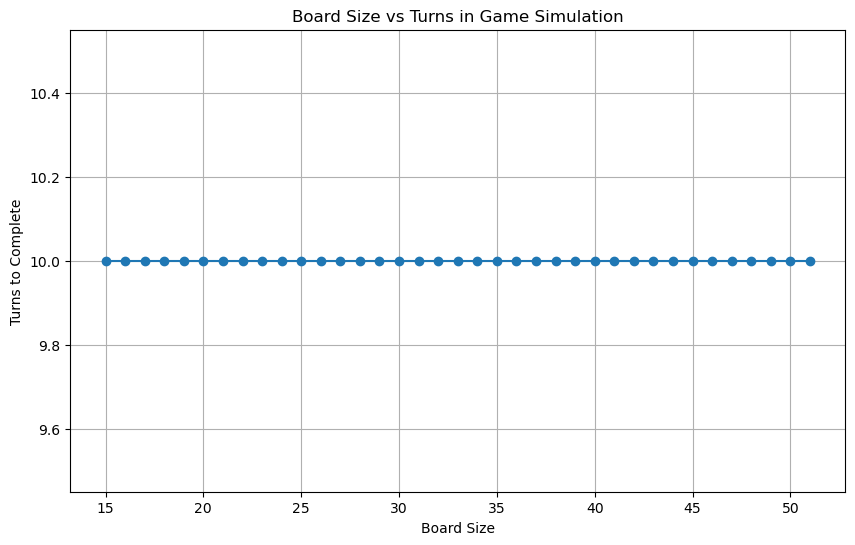

In [110]:
turns_list = []
for board_size in range(15, 52):
    turns, _, _, _ = full_game_sim(board_size, 10, 4, 100)
    turns_list.append(turns)

plt.figure(figsize=(10, 6))
plt.plot(range(15, 52), turns_list, marker='o', linestyle='-')
plt.xlabel("Board Size")
plt.ylabel("Turns to Complete")
plt.title("Board Size vs Turns in Game Simulation")
plt.grid()
plt.show()

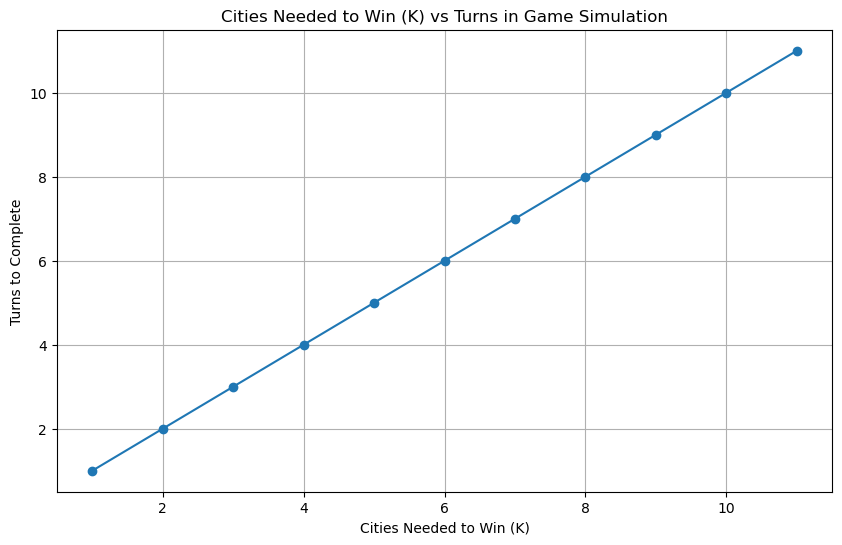

In [127]:
turns_list = []
for K in range(1, 12):
    turns, _, _, _ = full_game_sim(52, K, 4, 100)
    turns_list.append(turns)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 12), turns_list, marker='o', linestyle='-')
plt.xlabel("Cities Needed to Win (K)")
plt.ylabel("Turns to Complete")
plt.title("Cities Needed to Win (K) vs Turns in Game Simulation")
plt.grid()
plt.show()

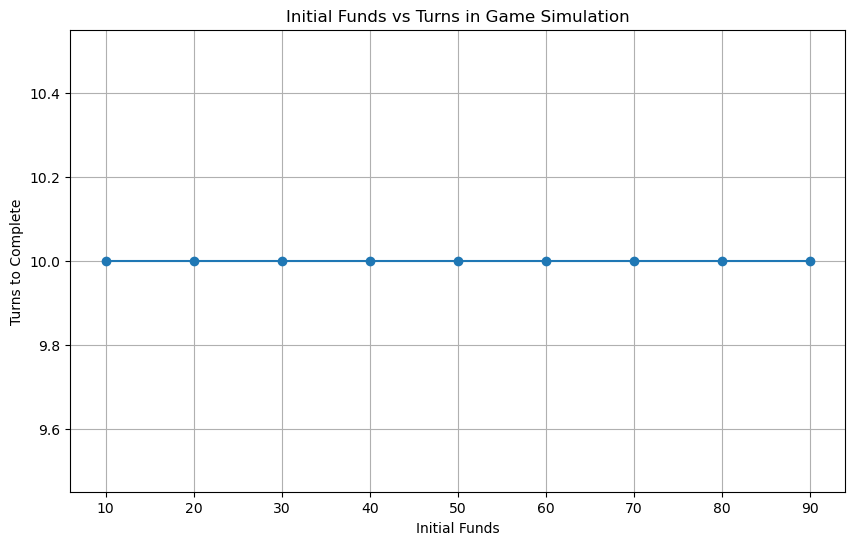

In [128]:
turns_list = []
for f in range(10, 100, 10):
    turns, _, _, _ = full_game_sim(52, 10, 4, f)
    turns_list.append(turns)

plt.figure(figsize=(10, 6))
plt.plot(range(10, 100, 10), turns_list, marker='o', linestyle='-')
plt.xlabel("Initial Funds")
plt.ylabel("Turns to Complete")
plt.title("Initial Funds vs Turns in Game Simulation")
plt.grid()
plt.show()

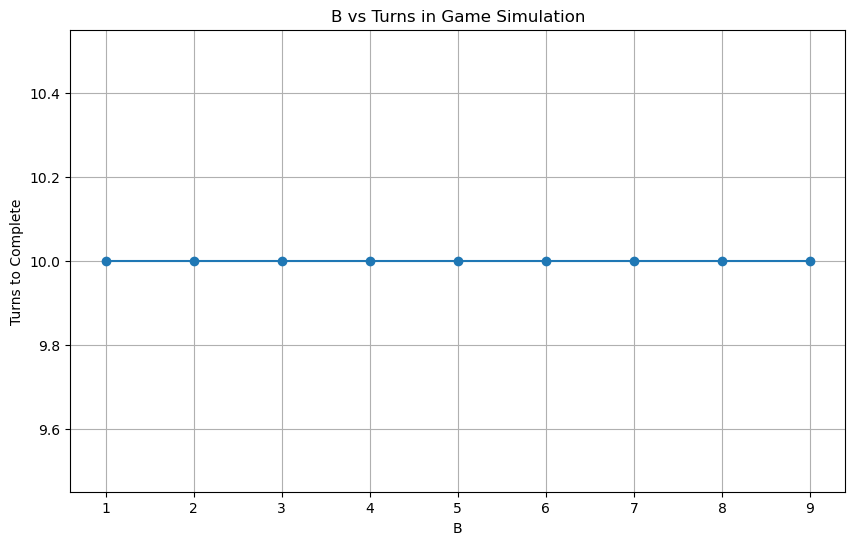

In [131]:
turns_list = []
for B in range(1, 10):
    turns, _, _, _ = full_game_sim(52, 10, B, 100)
    turns_list.append(turns)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), turns_list, marker='o', linestyle='-')
plt.xlabel("B")
plt.ylabel("Turns to Complete")
plt.title("B vs Turns in Game Simulation")
plt.grid()
plt.show()

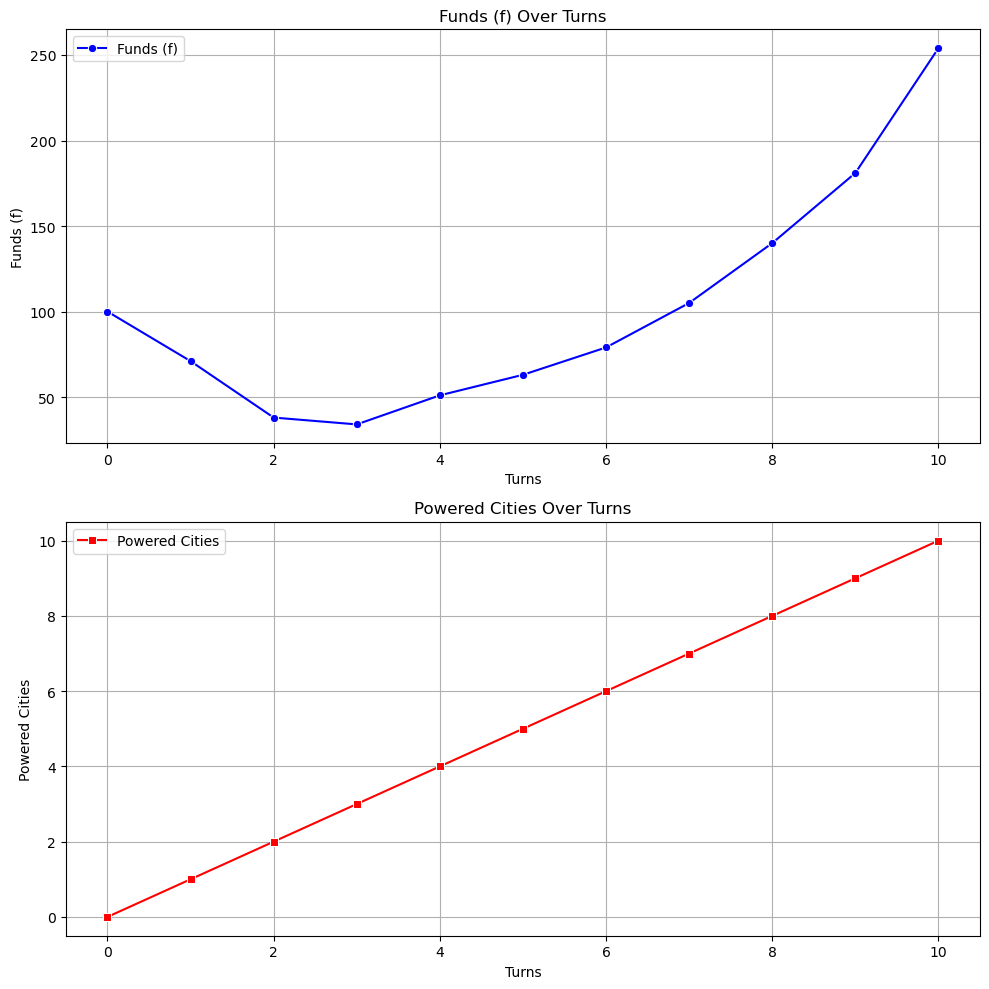

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

# Run the simulation
board_size = 25  # Example value, modify as needed
K = 10
B = 4
f = 100

turns, f_history, powered_history, P_player_history = full_game_sim(board_size, K, B, f)

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # Two rows, one column

# Plot f_history in the first subplot using seaborn
sns.lineplot(x=range(turns + 1), y=f_history, label="Funds (f)", color="blue", marker="o", ax=axs[0])
axs[0].set_xlabel("Turns")
axs[0].set_ylabel("Funds (f)")
axs[0].set_title("Funds (f) Over Turns")
axs[0].legend()
axs[0].grid(True)

# Plot powered_history in the second subplot using seaborn
sns.lineplot(x=range(turns + 1), y=powered_history, label="Powered Cities", color="red", marker="s", ax=axs[1])
axs[1].set_xlabel("Turns")
axs[1].set_ylabel("Powered Cities")
axs[1].set_title("Powered Cities Over Turns")
axs[1].legend()
axs[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
